# SMOTE Modeling

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/cleaned_data.csv')

df.head()

,HEFAMINC,HRNUMHOU,PRTAGE,PERET1,PEHRUSLT,PRNMCHLD,QSTNUM,HESP6,HESP7,HESP7A,...,race,marital_status,food_pantry,has_dis,service_status,job_loss,type_job,in_union,in_school,has_stamps
0,100000,4,30,0,60,2,1,0,0,0,...,White,yes,Unknown,No,No,No,ForProf,No,No,no
1,75000,3,20,0,40,1,2,0,0,0,...,White,yes,Unknown,No,No,No,ForProf,No,College,no
2,25000,3,20,0,0,1,5,0,0,2,...,White,yes,Yes,No,No,No,0,No,No,no
3,50000,1,20,0,40,0,6,0,0,0,...,Black,no,Yes,No,No,No,ForProf,No,No,no
4,150000,6,40,0,32,0,7,0,0,0,...,White,yes,Yes,No,No,No,Self-emp,No,No,no


### Final Cleaning Steps 

In [3]:
df.replace(['yes', 'no'], [1, 0], inplace=True)
df['is_metro'] = df['is_metro'].map({'Metro':1, 'No':0}) 
df['has_dis'] = df['has_dis'].map({'Yes':1, 'No':0})
df['in_school'] = df['in_school'].map({'College':1, 'HS':1, 'No':0})
df['in_union'] = df['in_union'].map({'Yes':1, 'No':0})
df['job_loss'] = df['job_loss'].map({'Lost':1, 'Quit':1, 'Temp':1, 'No':0})
df['service_status'] = df['service_status'].map({'Yes':1, 'No':0})
df['sex'] = df['sex'].map({'Male':1, 'Female':0})
df.drop('QSTNUM', axis=1, inplace=True)

### Pre-Processing Steps

#### Target Encoding

The same target encoding function that was used for the previous modeling notebook for this modeling notebook

In [4]:
#target encoding categorical variables
# arguments needed are dataframe to reference, column to find mean by, 
    # target column to base mean on, and the weight which was recommended as 10
def target_encode(df, by, on, m):
    
    # getting mean from our target column
    mean = df[on].mean()
    
    #getting count of amount of values and the mean
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    n = agg['count']
    means = agg['mean']
    
    # calculating smooth means by multiplying the num of variables with the means 
     # adding that to the weighted mean and dividing by the sum of counts and weight
    smooth = (n * means + m * mean)/ (n + m)
    
    # using .map() to replace the old values with the target encoded mean values
    return df[by].map(smooth)

In [5]:
df['state'] = target_encode(df, 'state', 'food_secure', m=10)
df['region'] = target_encode(df, 'region', 'food_secure', m=10)
df['division'] = target_encode(df, 'division', 'food_secure', m=10)
df['education'] = target_encode(df, 'education', 'food_secure', m=10)
df['race'] = target_encode(df, 'race', 'food_secure', m=10)
df['food_pantry'] = target_encode(df, 'food_pantry', 'food_secure', m=10)
df['type_job'] = target_encode(df, 'type_job', 'food_secure', m=10)

In [35]:
X = df.drop('food_secure', axis=1)

y = df['food_secure']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [63]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [64]:
sm = SMOTE()

Xsm_train, ysm_train = sm.fit_sample(X_train_sc, y_train)

In [65]:
print(pd.Series(ysm_train).value_counts())

1    32114
0    32114
Name: food_secure, dtype: int64


### Logistic Regression with SMOTE

In [66]:
lr = LogisticRegression()

lr.fit(Xsm_train, ysm_train)

LogisticRegression()

In [67]:
print(f'Training score:', lr.score(Xsm_train, ysm_train))
print(f'Testing score:', lr.score(X_test_sc, y_test))

Training score: 0.8833686242760167
Testing score: 0.8904235727440147


In [68]:
y_preds = lr.predict(X_test_sc)

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

print(confusion_matrix(y_test, y_preds))

[[7179  849]
 [ 222 1524]]


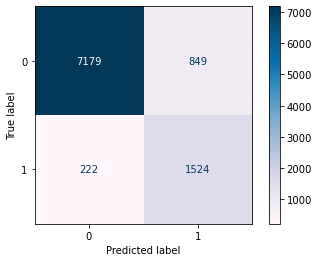

In [69]:
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='PuBu');

In [70]:
lr_sens = tp / (tp + fn)

print(f"Sensitivity score: ", lr_sens)

Sensitivity score:  0.872852233676976


In [71]:
lr_spec = tn / (tn + fn)

print(f"Specificity score: ", lr_spec)

Specificity score:  0.9700040535062829


In [72]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      8028
           1       0.64      0.87      0.74      1746

    accuracy                           0.89      9774
   macro avg       0.81      0.88      0.84      9774
weighted avg       0.91      0.89      0.90      9774



### SMOTE Pipeline

In [73]:
pipe = Pipeline([('sclae', StandardScaler()),
                 ('sampling', SMOTE()),
                 ('logreg', LogisticRegression())])

In [74]:
pipe_params = {'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
               'sampling__k_neighbors': [3, 5, 7],
               'logreg__C': [0.1, 0.5, 1]
}

In [75]:
grid = GridSearchCV(pipe,
                    pipe_params,
                    cv=5,
                    verbose=1)

In [76]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sclae', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 0.5, 1],
                         'sampling__k_neighbors': [3, 5, 7],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             verbose=1)

In [77]:
print(f"Score on training data:", grid.score(X_train, y_train))
print(f"Score on testing data:", grid.score(X_test, y_test))

Score on training data: 0.9360036832412523
Score on testing data: 0.9405565786781256


In [78]:
grid_preds = grid.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, grid_preds).ravel()

print(confusion_matrix(y_test, grid_preds))

[[7944   84]
 [ 497 1249]]


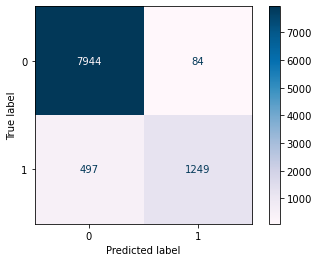

In [79]:
plot_confusion_matrix(grid, X_test, y_test, cmap='PuBu');

In [80]:
print(classification_report(y_test, grid_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8028
           1       0.94      0.72      0.81      1746

    accuracy                           0.94      9774
   macro avg       0.94      0.85      0.89      9774
weighted avg       0.94      0.94      0.94      9774



### ADASYN and Log Reg

In [81]:
ada = ADASYN()

X_train_ada, y_train_ada = ada.fit_sample(X_train_sc, y_train)

In [82]:
print(pd.Series(y_train_ada).value_counts())

1    32587
0    32114
Name: food_secure, dtype: int64


In [83]:
lr = LogisticRegression()

lr.fit(X_train_ada, y_train_ada)

LogisticRegression()

In [84]:
print(f'Training score:', lr.score(X_train_ada, y_train_ada))
print(f'Testing score:', lr.score(X_test_sc, y_test))

Training score: 0.8042225004250321
Testing score: 0.8782484141600164
